## Classical image denoising algorithms for autumn school in University of Cambridge

In this notebook there are five different image denoising algorithms which have been coded mostly with a Python library called "Operator Discretization Library (ODL)". <br>
Before iterative algorithms there is a little bit of mathematical background on what is happening in coming code section and hopefully it helps to understand the code.

In [3]:
### The packages needed for this notebook to run through.

import odl
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# from select_image import select_image
# from select_geometry import geometry_and_ray_trafo
# from select_algorithm import algorithm

In [4]:
### Here one loads the image which is used in these classical algorithms. 

### Define your own path to the image.
path = r'C:\Users\Antti\Downloads\usable_full_AGD_50_000257_19.tiff'

### Load the image.
image = cv.imread(path, cv.IMREAD_UNCHANGED)
image = image[90:410, 90:410]
# image = image[0:320:factor, 0:320:factor]

### Normalizing the image and taking its shape.
image = image / np.max(np.max(image))
shape = np.shape(image)

### Fan beam geometry and ray transform:

In the next code section one defines a fan beam geometry which simulates the geometry of the CT-scan. <br>
After the geometry is defined, one defines a domain for ray transform and ray transform itself.

In [5]:
### There is couple of parameters:

### What kind measurement environment one wants to choose.
### Possible options are 'full', 'sparse', 'limited'.
setup = 'sparse'

### Factor down amount of the detection lines, must be int.
factor_lines = 1

### Radius from the source to object.
source_radius = 2

### Radius from the object to detector.
detector_radius = 1

if setup == 'full':
    angles = odl.uniform_partition(0, 2*np.pi, 360)
    lines = odl.uniform_partition(-np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'sparse':
    angle_measurements = 50
    line_measurements = int(1024/factor_lines)
    angles = odl.uniform_partition(0, 2*np.pi, angle_measurements)
    lines = odl.uniform_partition(-1*np.pi, np.pi, line_measurements)
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'limited':
    starting_angle = 0
    final_angle = np.pi * 1/2
    angles = odl.uniform_partition(starting_angle, final_angle, 360)
    lines = odl.uniform_partition(-1*np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)


### The domain is defined here, there is couple of parameters:

### Imagine a box in 2D-plane with this parameter being the most southwest point of the box.
min_domain_corner = [-1,-1]

### Imagine a box in 2D-plane with this parameter being the most northeast point of the box.
max_domain_corner = [1,1]

### Number of samples per axis.
shape = shape

### Data type 
dtype = 'float'

domain = odl.uniform_discr(min_domain_corner, max_domain_corner, shape=shape, dtype=dtype)

### The ray transform is defined here

device = 'astra_cpu'

ray_transform = odl.tomo.RayTransform(domain, geometry, impl=device)

### Sinogram and noise

Next up is using the ray transform to obtain a sinogram from the image. <br>
After that one can/will add there noise, in this notebook Gaussian noise is used.

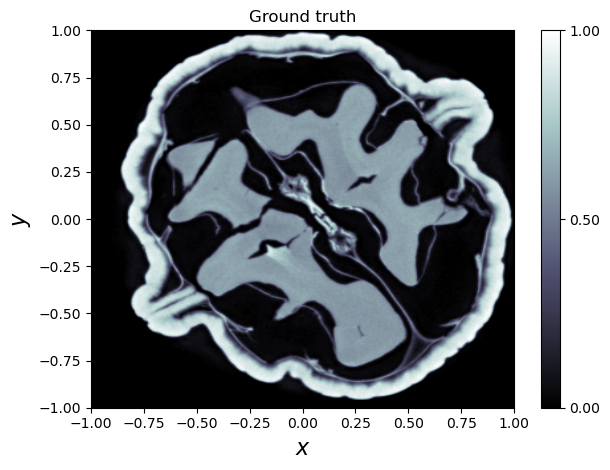

<Figure size 640x480 with 0 Axes>

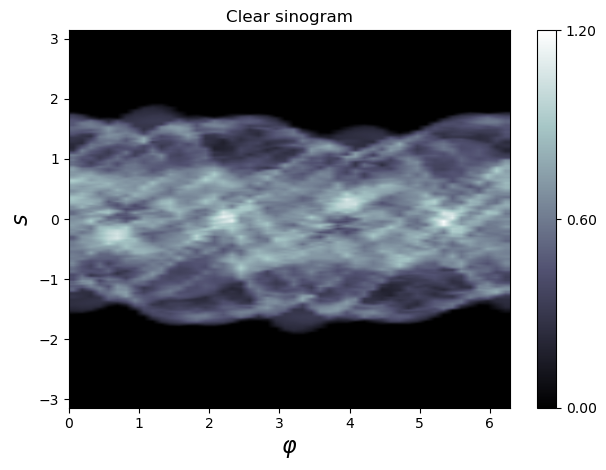

<Figure size 640x480 with 0 Axes>

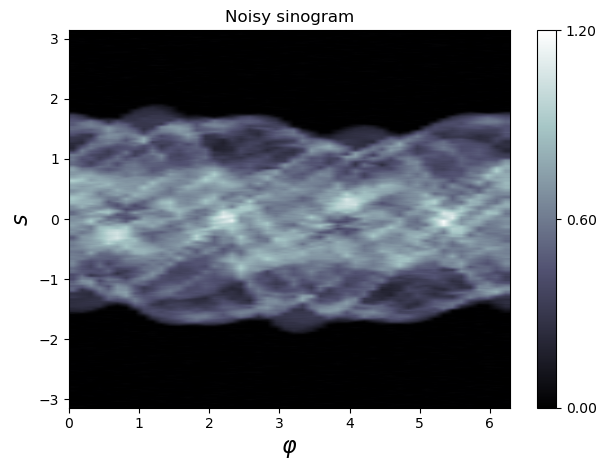

<Figure size 640x480 with 0 Axes>

In [6]:
### First convert image into ODL form
image = domain.element(image)

### Use ray transform to the image to obtain sinogram
sinogram = ray_transform(image)

### Parameters for the Gaussian noise
mean = 0.0
variance = 0.0002
sigma = variance ** 0.5

### Create noisy sinogram
noisy_sinogram = sinogram + np.random.normal(mean, sigma, size=(np.shape(sinogram)[0], np.shape(sinogram)[1]))
noisy_sinogram = np.maximum(noisy_sinogram,0)
image.show('Ground truth')
sinogram.show('Clear sinogram')
noisy_sinogram.show('Noisy sinogram')
plt.show()

## Reconstruction methods

Last sections contains different kind of reconstruction algorithms. <br>

### Filtered Back Projection (FBP):

This is the approximate inverse of ray transform. <br>
This is easy to define in the ODL as one can see below.

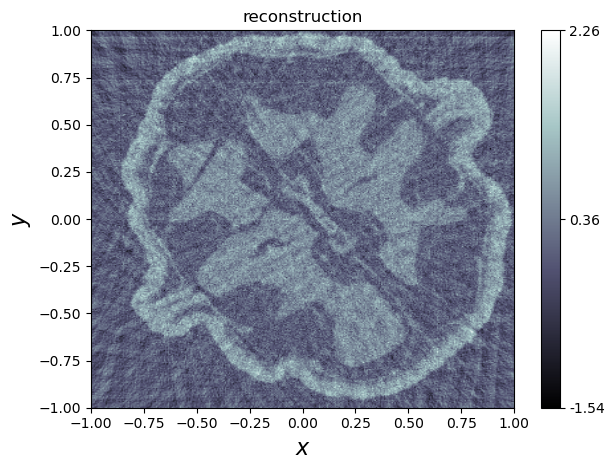

<Figure size 640x480 with 0 Axes>

In [7]:
### There is function in ODL to create FBP operator:
FBP_operator = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo=ray_transform, padding=1)

### One just applies the noisy sinogram with just defined FBP operator and gets a reconstruction out.
reconstruction = FBP_operator(noisy_sinogram)

### Because in these sections the images are plotted in ODL domain the next thing is needed:
reconstruction = domain.element(reconstruction)

### Plotting the reconstructed image
reconstruction.show('reconstruction')
plt.show()

### Tikhonov regularization

This is the first iterative algorithm. It is based on a regularization theory and it is a minimization problem formulated as <br>
$$
\argmin_x \mathcal{E}(x) = \argmin_{x} \{ ||Ax - y||^2_2 + \lambda ||Bx||^2_2 \}
$$
Above minimization problem can be understood such that the final answer $x$ should give a good balance between small residual in the first norm and a small value in $L^2$-norm. <br> 
That minimization problem can be solved iteratively with gradient descent. For one to solve the iterative step, the first thing to do is take a derivative of the minimization problem with respect to $x$ and setting it equal to zero. <br>
That then yields an equation which looks like 
$$
\nabla_x \mathcal{E}(x) = (A^T A + \lambda B^T B)x - A^T y
$$
In this case we will also set that $B = I$ and that then gives 
$$
\nabla_x \mathcal{E}(x) = (A^T A + \lambda I)x - A^T y = Tx - b
$$
That equation is now used in the gradient descent such that the iterative step is given as
$$
x_{i+1} = x_i - \beta \nabla_x \mathcal{E}(x_i) = x_i - \beta (T x_i - b)
$$
Below there is then a code with this formulation.

Iteration 0/50


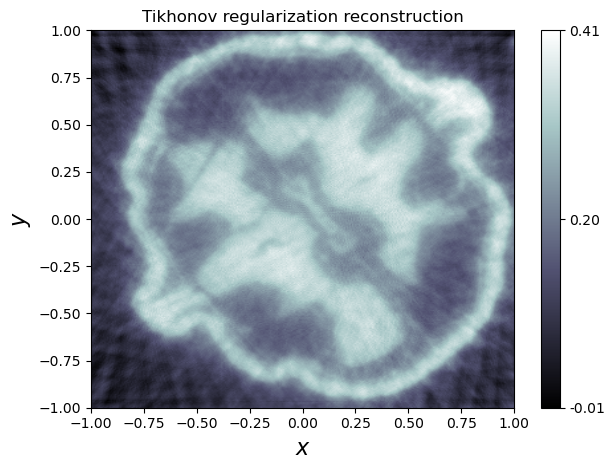

<Figure size 640x480 with 0 Axes>

In [8]:
### Renaming ray transform as "operator"
operator = ray_transform

### Defining step size "beta" which is depends on the value of the operator norm
operator_norm = 1.1 * odl.power_method_opnorm(operator)
beta = 1/(operator_norm**2)

### This is how one defines ideneity operator in ODL
id = odl.IdentityOperator(domain)

### Lambda parameter
lam = 5

### Operator "T" defined just as written in equation above
T = operator.adjoint * operator + lam *  id.adjoint * id

# Tgrad = operator.adjoint * operator

### Evaluating "b" like written above
b = operator.adjoint(noisy_sinogram)

### Amount of iterative steps
iterations = 200

### Starting point f_0 is zero matrix
f_new = domain.zero()

### Here is the iterative loop
for k in range(iterations):
    if k % 50 == 0:
        print(f'Iteration {k}/{iterations}')
    
    ### Iterative step
    f_old = f_new
    f_new = f_old - beta * (T(f_old) - b)
    # f_old = f_new

tikhonov_reconstruction = domain.element(f_new)
tikhonov_reconstruction.show('Tikhonov regularization reconstruction')
plt.show()

One other option is to smoothly approximate TV-regularization term with some constant $\beta > 0$ such that it get a form
$$
\mathcal{R}(x) = || |\nabla x|_\beta ||_1 = \left\| \sqrt{\sum_i (\partial_i x)^2 + \beta^2} \right\|_1
$$
which is now differentiable. <br>
The gradient of the regularizer is given by
$$
\nabla_x \mathcal{R}(x) = \nabla^T \cdot \left( \frac{\nabla x}{\sqrt{\sum_i (\partial_i x)² + \beta^2}} \right)
$$
Then a gradient of the data fidality term is
$$
\nabla_x [ || Ax - y ||_2 ] = 2 A^* (Ax - y) = T_1 (Ax -y) = T_2 x - T_1 y = T_2 x - b
$$
Now one can use the basic gradient descent algorithm to obtain reconstruction. Code implementation is shown below.

Iteration 0/1000


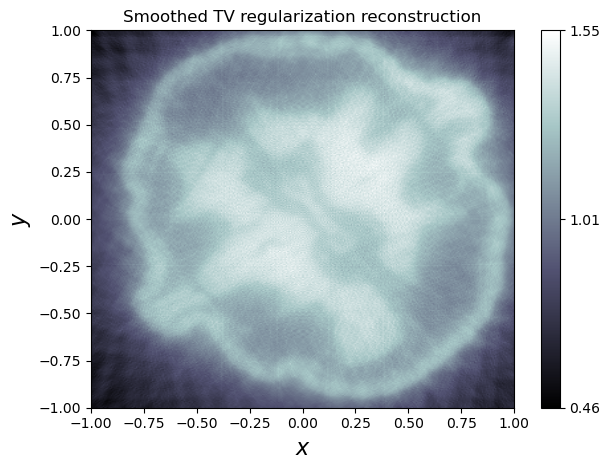

<Figure size 640x480 with 0 Axes>

Iteration 50/1000


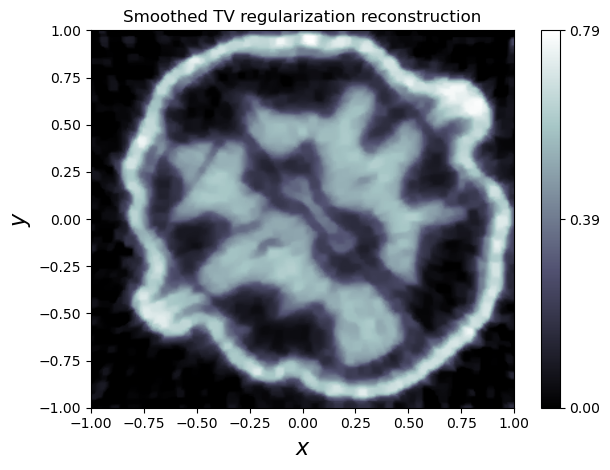

<Figure size 640x480 with 0 Axes>

Iteration 100/1000


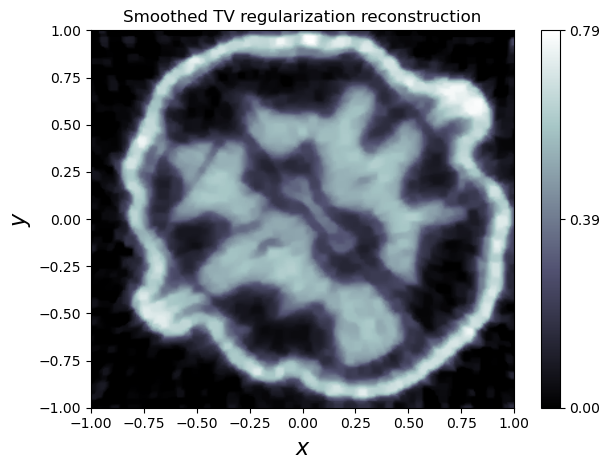

<Figure size 640x480 with 0 Axes>

Iteration 150/1000


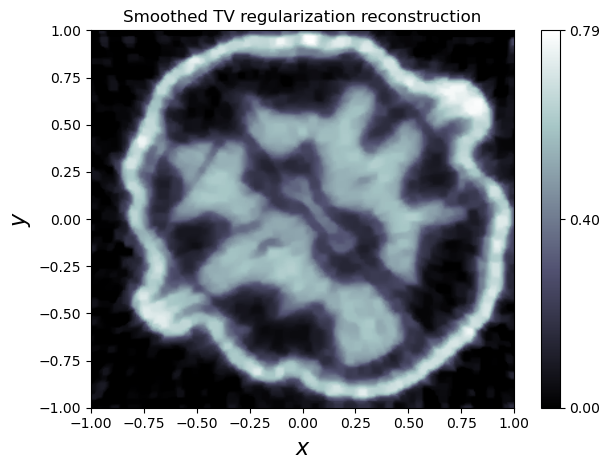

<Figure size 640x480 with 0 Axes>

Iteration 200/1000


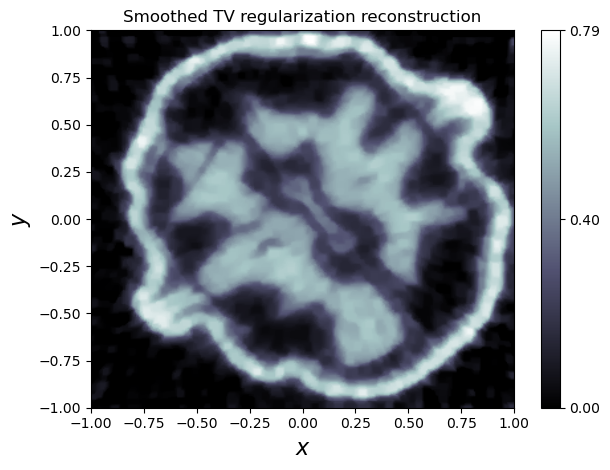

<Figure size 640x480 with 0 Axes>

Iteration 250/1000


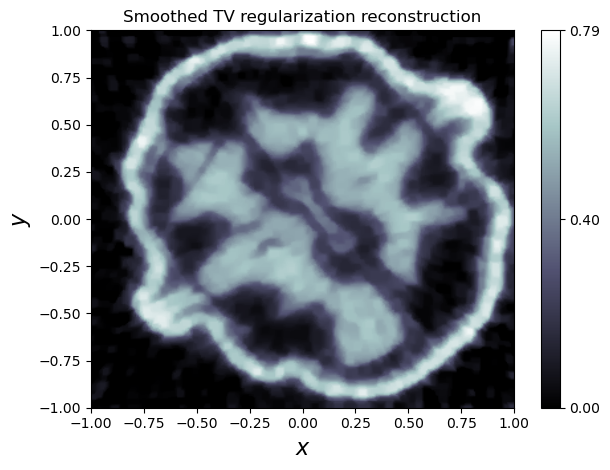

<Figure size 640x480 with 0 Axes>

Iteration 300/1000


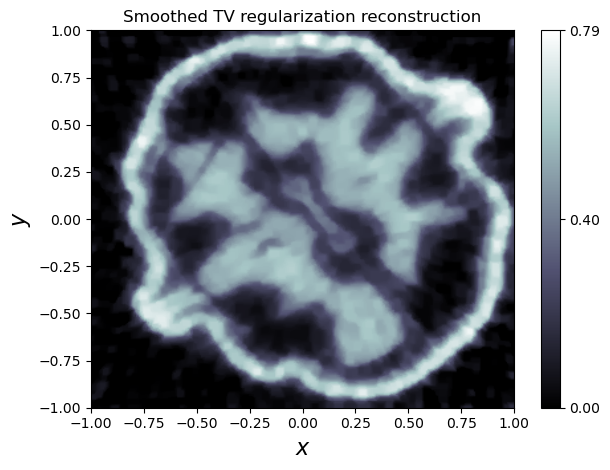

<Figure size 640x480 with 0 Axes>

Iteration 350/1000


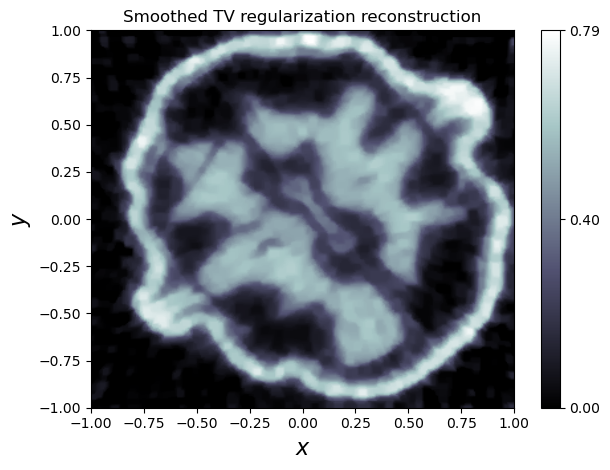

<Figure size 640x480 with 0 Axes>

Iteration 400/1000


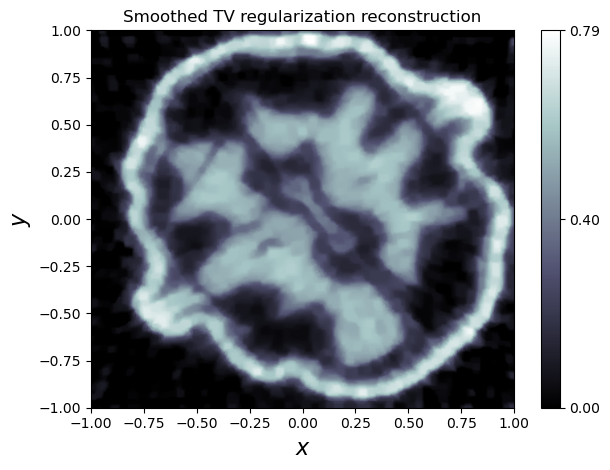

<Figure size 640x480 with 0 Axes>

Iteration 450/1000


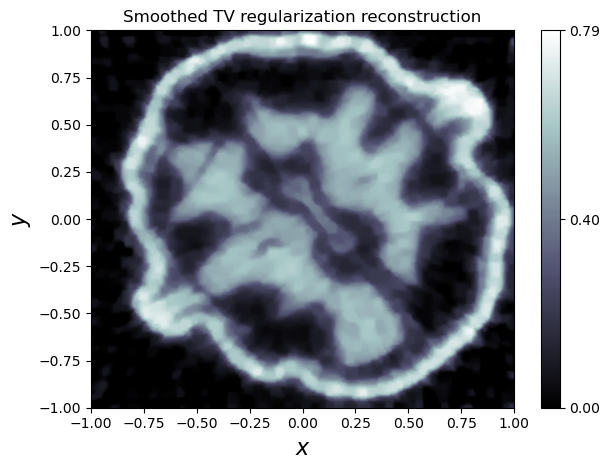

<Figure size 640x480 with 0 Axes>

Iteration 500/1000


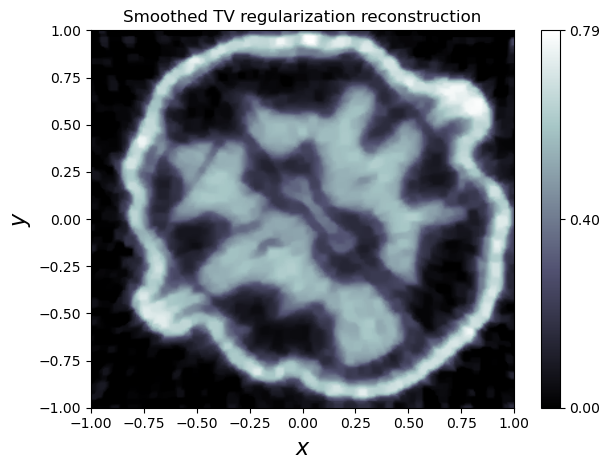

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [10]:
### First one defines the gradient over the domain of the problem
gradient = odl.Gradient(domain)

### Defining operators given above
T_1 = 2*operator.adjoint
T_2 = T_1*operator


### Evaluating b = T_1 * g
b = T_1(noisy_sinogram)

### Initializing f to zero
f_new =  operator.adjoint(noisy_sinogram) / operator_norm

### Amount of iterations
iterations = 1000

### Parameters
step_size = 1e-4
max_step = 1/ (operator_norm**2)
beta = 1e-6 
lam = 1e-3

denomi = np.sqrt(gradient(f_new)**2 + beta)
division = gradient(f_new) / denomi
gradCur = (T_2(f_new) - b) + lam * gradient.adjoint(division)

for k in range(iterations):
    if k % 50 == 0:
        print(f'Iteration {k}/{iterations}')
        smoothed_reconstruction = domain.element(f_new)
        smoothed_reconstruction.show('Smoothed TV regularization reconstruction')
        # grad.show('gradient')
        plt.show()
    
    ### Iterative step
    f_old = f_new
    grad_old=gradCur
    f_new = np.maximum(f_new - step_size * gradCur,0)
 
    denomi = np.sqrt(gradient(f_new)**2 + beta)
    division = gradient(f_new) / denomi
    gradCur = (T_2(f_new) - b) + lam * gradient.adjoint(division)


    step_size =np.minimum(np.sum(np.multiply(f_new-f_old, f_new-f_old)) / np.sum(np.multiply(f_new-f_old,gradCur - grad_old)),max_step)
    
    

const = domain.one() * (np.sqrt(np.sum(np.sum(gradient(f_old)**2)) + beta))
division = gradient(f_old) / const
# grad = (T_2(f_old) - b) - lam * divergence(division)
# grad = domain.element(grad)
smoothed_reconstruction = domain.element(f_new)
smoothed_reconstruction.show('Smoothed TV regularization reconstruction')
# grad.show('gradient')
plt.show()
